<a href="https://colab.research.google.com/github/LadislavVasina1/AudioAugmentor_public/blob/main/OrbitalMechanics_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scipy numpy poliastro astropy numba plotly matplotlib pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.7/162.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.8/994.8 kB 23.2 MB/s eta 0:00:00
  Attempting uninstall: astropy
    Found existing installation: astropy 6.1.4
    Uninstalling astropy-6.1.4:
      Successfully uninstalled astropy-6.1.4


Import needed libraries

In [ ]:
import pprint
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from astroquery.jplsbdb import SBDB
from poliastro.bodies import Sun
from poliastro.twobody import Orbit
from poliastro.plotting import StaticOrbitPlotter
from poliastro.frames import Planes
from astropy.time import Time
from astropy import units as u
from IPython.display import display, HTML

sin = np.sin
cos = np.cos
tan = np.tan
arctan = np.arctan
pi = np.pi

Setup needed parameters

In [ ]:
EARTH_PARAMS = {
    # 'a':           1, # semi-major axis [AU]
    'a':           1 * 149597870.691, # semi-major axis [km]
    'e':           0.0167, # eccentricity
    # 'i':           0, # inclination [deg]
    'i':           np.deg2rad(0), # inclination [rad]
    # 'raan':       -11.26064, # longitude of ascending node Ω [deg]
    'raan':       np.deg2rad(-11.26064), # longitude of ascending node Ω [rad]
    # 'lower_omega': 114.20783, # argument of perihel ω [deg]
    'lower_omega': np.deg2rad(114.20783), # argument of perihel ω [rad]
    'T0':          2451547.5191, # time of passage through perighel [JDT]
}

LV2021_PARAMS = {
    # 'a':           1.3117, # semi-major axis [AU]
    'a':           1.3117 * 149597870.691, # semi-major axis [km]196227526.98538473
    'e':           0.4316, # eccentricity
    # 'i':           16.4732, # inclination [deg]
    'i':           np.deg2rad(16.4732), # inclination [rad]
    # 'raan':        246.4812, # longitude of ascending node Ω [deg]
    'raan':        np.deg2rad(246.4812), # longitude of ascending node Ω [rad]
    # 'lower_omega': 276.6864, # argument of perihel ω [deg]
    'lower_omega': np.deg2rad(276.6864), # argument of perihel ω [rad]
    'T0':          2459305.24448, # time of passage through perighel [JDT]
}

May_27_2021_1320_JDT = 2459362.0555
print(EARTH_PARAMS)
print(LV2021_PARAMS)

{'a': 149597870.691, 'e': 0.0167, 'i': 0.0, 'raan': -0.1965352438817743, 'lower_omega': 1.9933026650579555, 'T0': 2451547.5191}
{'a': 196227526.98538473, 'e': 0.4316, 'i': 0.2875115783395299, 'raan': 4.301908484266647, 'lower_omega': 4.829088675490039, 'T0': 2459305.24448}


Define transformation matrices

In [ ]:
def create_transform_ge_p(ω, Ω, i):
  return np.matrix([
      [
          cos(ω)*cos(Ω)-sin(ω)*sin(Ω)*cos(i),
          cos(ω)*sin(Ω)+sin(ω)*cos(Ω)*cos(i),
          sin(ω)*sin(i)
      ],
      [
          -sin(ω)*cos(Ω)-cos(ω)*sin(Ω)*cos(i),
          -sin(ω)*sin(Ω)+cos(ω)*cos(Ω)*cos(i),
          cos(ω)*sin(i)
      ],
      [
          sin(Ω)*sin(i),
          -cos(Ω)*sin(i),
          cos(i)
      ]
  ])

In [ ]:
def create_transform_p_ge(ω, Ω, i):
  return np.matrix([
      [
          cos(ω)*cos(Ω)-sin(ω)*sin(Ω)*cos(i),
          -sin(ω)*cos(Ω)-cos(ω)*sin(Ω)*cos(i),
          sin(Ω)*sin(i)
      ],
      [
          cos(ω)*sin(Ω)+sin(ω)*cos(Ω)*cos(i),
          -sin(ω)*sin(Ω)+cos(ω)*cos(Ω)*cos(i),
          -cos(Ω)*sin(i)
      ],
      [
          sin(ω)*sin(i),
          cos(ω)*sin(i),
          cos(i)
      ]
  ])

In [ ]:
Transform_GE_P_earth = create_transform_ge_p(
    ω=EARTH_PARAMS['lower_omega'],
    Ω=EARTH_PARAMS['raan'],
    i=EARTH_PARAMS['i']
)

Transform_GE_P_lv2021 = create_transform_ge_p(
    ω=LV2021_PARAMS['lower_omega'],
    Ω=LV2021_PARAMS['raan'],
    i=LV2021_PARAMS['i']
)
# print(f'Transform_GE_P_earth:\n {Transform_GE_P_earth}\n')
# print(f'Transform_GE_P_lv2021:\n {Transform_GE_P_lv2021}\n')

Transform_P_GE_earth = create_transform_p_ge(
    ω=EARTH_PARAMS['lower_omega'],
    Ω=EARTH_PARAMS['raan'],
    i=EARTH_PARAMS['i']
)

Transform_P_GE_lv2021 = create_transform_p_ge(
    ω=LV2021_PARAMS['lower_omega'],
    Ω=LV2021_PARAMS['raan'],
    i=LV2021_PARAMS['i']
)


# print(f'Transform_P_GE_earth:\n {Transform_P_GE_earth}\n')
# print(f'Transform_P_GE_lv2021:\n {Transform_P_GE_lv2021}\n')

# Kepler's equation $$M = E - e  sin  E$$

**M** [rad] ... Mean anomaly defined as $$ M = n(t-T_0)$$
*where*

**n** [rad/s] ... mean motion defined as $$ n = 2\pi T = \sqrt{(\mu /a^3)}$$
**t** ... time for which the mean anomaly is calculated

**T_0** ... origin of time integration (usualy taken as time of perigee passage)


$$\mu_{Earth} = 398 600 km^3/s^2$$
$$\mu_{Sun} = 1.32712440018 × 10^{11} km^3/s^2$$

In [ ]:
μ_Earth = 398600 # km^3/s^2
μ_Sun = 1.32712440018e+11 # km^3/s^2
# μ_Sun = 2.959122083e-4 # AU^3/day^2


In [ ]:
def mean_motion_n(μ, a):
  n = np.sqrt(μ/np.power(a, 3))
  return n

In [ ]:
def mean_anomaly_M(n, t, T0):
  M = n * (t - T0)
  return M

In [ ]:
n = mean_motion_n(μ_Sun, EARTH_PARAMS['a'])
M = mean_anomaly_M(n=n, t=May_27_2021_1320_JDT * 86400, T0=EARTH_PARAMS['T0'] * 86400)

print(f'mean motion for Earth  n = {n} [rad/s]')
print(f'mean motion for Earth  n = {n*86400} [rad/day]')
print(f'mean anomaly for Earth M = {M} [rad]')
print(f'mean anomaly for Earth M = {M*180/np.pi} [deg]')

mean motion for Earth  n = 1.990983674768616e-07 [rad/s]
mean motion for Earth  n = 0.017202098950000844 [rad/day]
mean anomaly for Earth M = 134.4264284011756 [rad]
mean anomaly for Earth M = 7702.067002404904 [deg]


Kepler equation cannot be solved directly thus we use iterative method below:
$$ E_0 = M $$
$$ E_{i+1} = M + esinE_i $$

In [ ]:
def iterative_method_for_E(M, e, num_iter, verbose=False):
  final_E = M
  for i in range(num_iter):
    final_E = M + e*sin(final_E)
    if i%5 == 0:
        print(f'E after {i}. iterations = {final_E} [rad]') if verbose else None
  print(f'E after {num_iter}. iterations = {final_E} [rad]') if verbose else None
  print(f'E after {num_iter}. iterations = {final_E*180/np.pi} [deg]') if verbose else None
  return final_E

print('EARTH')
E = iterative_method_for_E(M, EARTH_PARAMS['e'], 10, verbose=True)

EARTH
E after 0. iterations = 134.43669455157521 [rad]
E after 5. iterations = 134.4365605680827 [rad]
E after 10. iterations = 134.43656056808277 [rad]
E after 10. iterations = 7702.647532806008 [deg]


Now we need to calculate true anomaly using this expresion:
$$ tan \frac{\theta}{2} = \sqrt{(\frac{1+e}{1-e})}tan \frac{E}{2}  $$
$$ ⇓ $$
$$ \theta = 2 arctan(\sqrt{(\frac{1+e}{1-e})}tan \frac{E}{2})$$

In [ ]:
def true_anomaly_θ(E, e):
  θ = 2*arctan(np.sqrt((1+e)/(1-e))*tan(E/2))
  return θ


In [ ]:
θ = true_anomaly_θ(E, EARTH_PARAMS['e'])
print(f'True anomaly of Earth θ = {θ} [rad]')
print(f'True anomaly of Earth θ = {θ*180/np.pi} [deg]')

True anomaly of Earth θ = 2.4997350869892982 [rad]
True anomaly of Earth θ = 143.2242703852545 [deg]


Now we calculate the state position vector
$$\begin{pmatrix}x \\y \\z\end{pmatrix} = r * \begin{pmatrix}cos(θ) \\sin(\theta) \\0\end{pmatrix} $$


**r** ... radius is calulated as $$ r = \frac{p}{1+ecos(\theta)} $$
**p** ... orbit parameter is calculated from the 1st Kepler law using $$ p=a(1-e^2) $$


In [ ]:
def orbit_parameter_p(a, e):
  return a * (1 - np.power(e, 2))

In [ ]:
def radius_r(p, e, θ):
  return (p)/(1 + (e * cos(θ)))

In [ ]:
p = orbit_parameter_p(a=EARTH_PARAMS['a'], e=EARTH_PARAMS['e'])
print(f'p = {p} [km]')
print(f'p = {p * 6.6845871226706E-9} [AU]\n')

r = radius_r(p=p, e=EARTH_PARAMS['e'], θ=θ)
print(f'r = {r} [km]')
print(f'r = {r * 6.6845871226706E-9} [AU]\n')

cosTheta_sinTheta_0_vector = np.matrix([
    [cos(θ)],
    [sin(θ)],
    [0]
]
)

x_y_z_vector = r * cosTheta_sinTheta_0_vector
print(f'x_y_z_vector [km]= \n{x_y_z_vector}')
print(f'x_y_z_vector [AU]= \n{x_y_z_vector * 6.6845871226706E-9}')

p = 149556149.340843 [km]
p = 0.9997211100000002 [AU]

r = 151583802.53278545 [km]
r = 1.0132751344161006 [AU]

x_y_z_vector [km]= 
[[-1.21416359e+08]
 [ 9.07508513e+07]
 [ 0.00000000e+00]]
x_y_z_vector [AU]= 
[[-0.81161823]
 [ 0.60663197]
 [ 0.        ]]


Now we calculate the state velocity vector
$$\begin{pmatrix}V_x \\V_y \\V_z\end{pmatrix} = \sqrt{(\frac{\mu}{p})} * \begin{pmatrix}-sin(θ) \\e+cos(\theta) \\0\end{pmatrix} $$


**p** ... orbit parameter is calculated from the 1st Kepler law using $$ p=a(1-e^2) $$


In [ ]:
p = orbit_parameter_p(a=EARTH_PARAMS['a'], e=EARTH_PARAMS['e'])
print(f'p = {p} [km]')
print(f'p = {p * 6.6845871226706E-9} [AU]\n')


minuSinusTheta_ePlusCosTheta_vector = np.matrix([
    [-sin(θ)],
    [EARTH_PARAMS['e'] + cos(θ)],
    [0]
]
)

Vx_Vy_Vz_vector = np.sqrt(μ_Sun/p) * minuSinusTheta_ePlusCosTheta_vector
print(f'Vx_Vy_Vz_vector [km/s] = \n{Vx_Vy_Vz_vector}')
print(f'Vx_Vy_Vz_vector [AU/s] = \n{Vx_Vy_Vz_vector * 6.6845871226706E-9}')

p = 149556149.340843 [km]
p = 0.9997211100000002 [AU]

Vx_Vy_Vz_vector [km/s] = 
[[-17.83411611]
 [-23.36294643]
 [  0.        ]]
Vx_Vy_Vz_vector [AU/s] = 
[[-1.19213703e-07]
 [-1.56171651e-07]
 [ 0.00000000e+00]]


Now when we have a state vector in perifocal coordinate system we convert it to geocentric equiatorial coordinate system using transformation matrix $$T_{P→GE}$$ which is defined at the begining of this file.

In [ ]:
Transform_P_GE_earth = create_transform_p_ge(
    ω=EARTH_PARAMS['lower_omega'],
    Ω=EARTH_PARAMS['raan'],
    i=EARTH_PARAMS['i']
)
print(f'Transform_P_GE_earth matrix = \n{Transform_P_GE_earth}\n')

final_earth_coordinates = Transform_P_GE_earth * x_y_z_vector
print(f'Final Earth coordinates [km] = \n {final_earth_coordinates}')
print(f'Final Earth coordinates [AU] = \n {final_earth_coordinates * 6.6845871226706E-9}\n')


final_earth_velocity = Transform_P_GE_earth * Vx_Vy_Vz_vector
print(f'Final Earth velocity [km/s] = \n {final_earth_velocity}')
print(f'Final Earth velocity [AU/s] = \n {final_earth_velocity * 6.6845871226706E-9}')

Transform_P_GE_earth matrix = 
[[-0.22405287 -0.97457699 -0.        ]
 [ 0.97457699 -0.22405287 -0.        ]
 [ 0.         -0.          1.        ]]

Final Earth coordinates [km] = 
 [[-6.12400074e+07]
 [-1.38662579e+08]
 [ 0.00000000e+00]]
Final Earth coordinates [AU] = 
 [[-0.40936416]
 [-0.92690209]
 [ 0.        ]]

Final Earth velocity [km/s] = 
 [[ 26.76477498]
 [-12.14618391]
 [  0.        ]]
Final Earth velocity [AU/s] = 
 [[ 1.78911470e-07]
 [-8.11922246e-08]
 [ 0.00000000e+00]]


In [ ]:
def prepare_data(body_params, result, time_in_JDT):
  result = [result]
  data = {
    'time_in_JDT': {
        'time_in_JDT': time_in_JDT
      },
     'body_given_values': {
         'a [km]': body_params['a'],
         'e': body_params['e'],
         'i [rad]': body_params['i'],
         'raan [rad]': body_params['raan'],
         'lower_omega [rad]': body_params['lower_omega'],
         'T0 [JDT]': body_params['T0'],
     },
     'body_calculated_values': {
         'n [rad/s]': result[0]['n'],
         'M [rad]': result[0]['M'],
         'E [rad]': result[0]['E'],
         'θ [rad]': result[0]['θ'],
         'p [km]': result[0]['p'],
         'r [km]': result[0]['r'],
         # Unpack the vectors into separate columns
         'x_p': result[0]['x_y_z_vector_perifocal'].tolist()[0][0], # Accessing elements of the matrices
         'y_p': result[0]['x_y_z_vector_perifocal'].tolist()[1][0],
         'z_p': result[0]['x_y_z_vector_perifocal'].tolist()[2][0],
         'Vx_p': result[0]['Vx_Vy_Vz_vector_perifocal'].tolist()[0][0],
         'Vy_p': result[0]['Vx_Vy_Vz_vector_perifocal'].tolist()[1][0],
         'Vz_p': result[0]['Vx_Vy_Vz_vector_perifocal'].tolist()[2][0],
         'x_ge': result[0]['final_body_coordinates_ge'].tolist()[0][0],
         'y_ge': result[0]['final_body_coordinates_ge'].tolist()[1][0],
         'z_ge': result[0]['final_body_coordinates_ge'].tolist()[2][0],
         'Vx_ge': result[0]['final_body_velocity_ge'].tolist()[0][0],
         'Vy_ge': result[0]['final_body_velocity_ge'].tolist()[1][0],
         'Vz_ge': result[0]['final_body_velocity_ge'].tolist()[2][0],
     }
  }

  return data


def plot_data(BODY_1_PARAMS, BODY_2_PARAMS, result, time_in_JDT):
  body_0_data = prepare_data(BODY_1_PARAMS, result[0], time_in_JDT)
  body_1_data = prepare_data(BODY_2_PARAMS, result[1], time_in_JDT)
  num_of_decimals = 10

  # Create DataFrames
  df1_body0 = pd.DataFrame(body_0_data['time_in_JDT'], index=['Time of the calculation']).T
  df2_body0 = pd.DataFrame(body_0_data['body_given_values'], index=[f'body_0_given_values']).T
  df3_body0 = pd.DataFrame(body_0_data['body_calculated_values'], index=[f'body_0_calculated_values']).T

  df1_body1 = pd.DataFrame(body_1_data['time_in_JDT'], index=['Time of the calculation']).T
  df2_body1 = pd.DataFrame(body_1_data['body_given_values'], index=[f'body_1_given_values']).T
  df3_body1 = pd.DataFrame(body_1_data['body_calculated_values'], index=[f'body_1_calculated_values']).T

  # Set float format
  pd.set_option('display.float_format', lambda x: f'%.{num_of_decimals}f' % x)

  # Display tables side-by-side using HTML
  display(HTML(f"<table><tr><td>{df1_body0.to_html()}</td><td>{df2_body0.to_html()}</td><td>{df2_body1.to_html()}</td><td>{df3_body0.to_html()}</td><td>{df3_body1.to_html()}</td></tr></table>"))

def plot_orbits_2d(bodies_params, result, time_in_JDT):
  # Get user input for orbital parameters
  # For simplicity, I'm using default values, but you should replace them with user input
  a1 = (bodies_params[0]['a'] * u.km).to(u.AU)
  ecc1 = bodies_params[0]['e'] * u.dimensionless_unscaled
  inc1 = (bodies_params[0]['i'] * u.rad).to(u.deg)
  raan1 = (bodies_params[0]['raan'] * u.rad).to(u.deg)
  argp1 = (bodies_params[0]['lower_omega'] * u.rad).to(u.deg)
  nu1 = (result[0]['θ'] * u.rad).to(u.deg)

  a2 = (bodies_params[1]['a'] * u.km).to(u.AU)
  ecc2 = bodies_params[1]['e'] * u.dimensionless_unscaled
  inc2 = (bodies_params[1]['i'] * u.rad).to(u.deg)
  raan2 = (bodies_params[1]['raan'] * u.rad).to(u.deg)
  argp2 = (bodies_params[1]['lower_omega'] * u.rad).to(u.deg)
  nu2 = (result[1]['θ'] * u.rad).to(u.deg)

  # Define the epoch

  # epoch = Time("2021-05-27 13:20:00", scale="utc")
  epoch = Time(time_in_JDT, format="jd", scale="tt")


  # Create the orbit objects
  orbit1 = Orbit.from_classical(Sun, a1, ecc1, inc1, raan1, argp1, nu1, epoch=epoch)
  orbit2 = Orbit.from_classical(Sun, a2, ecc2, inc2, raan2, argp2, nu2, epoch=epoch)

  # Create the plotter and plot the orbits
  plotter = StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)
  plotter.plot(orbit1, label="Body#1 orbit", color="blue")
  plotter.plot(orbit2, label="Body#2 orbit", color="red")

  return orbit1, orbit2

  # TrueAnomaly Earth = 143.2242703852545 deg
  # TrueAnomaly LV2021 = 83.04451694635759 deg


In [ ]:
def calculate_positions_velocities_of_two_bodies_orbiting_sun(
    BODY_1_PARAMS,
    BODY_2_PARAMS,
    time_in_JDT,
    verbose=False,
):
  init_dict = {
        'n': None,
        'M': None,
        'E': None,
        'θ': None,
        'p': None,
        'r': None,
        'x_y_z_vector_perifocal': None,
        'Vx_Vy_Vz_vector_perifocal': None,
        'final_body_coordinates_ge': None,
        'final_body_velocity_ge': None,
      }

  result = [init_dict, init_dict]

  μ_Sun = 1.32712440018e+11 # km^3/s^2

  param_enum = [BODY_1_PARAMS, BODY_2_PARAMS]

  for i, current_body_params in enumerate(param_enum):
    # n,M,E,θ,p,r,x_y_z_vector_perifocal,Vx_Vy_Vz_vector_perifocal,final_body_coordinates_ge,final_body_velocity_ge = 0,0,0,0,0,0,0,0,0,0
    print(f'\n\n\nBODY NO. {i}\nGIVEN PARAMS: {current_body_params}\n') if verbose else None

    ### Kepler's equation part

    # Getting mean motion and anomaly
    n = mean_motion_n(μ_Sun, current_body_params['a'])
    M = mean_anomaly_M(n, time_in_JDT*86400, current_body_params['T0']*86400)
    print(f'mean motion for body no. {i}  n = {n} [rad/s]') if verbose else None
    print(f'mean motion for body no. {i}  n = {n * 86400} [rad/day]') if verbose else None
    print(f'mean anomaly for body no. {i} M = {M} [rad]') if verbose else None

    # Using iterative method for getting E
    E = iterative_method_for_E(M, current_body_params['e'], 10, verbose=verbose)

    # Calculating true anomaly
    θ = true_anomaly_θ(E, current_body_params['e'])
    print(f'True anomaly θ = {θ} [rad]') if verbose else None
    print(f'True anomaly θ = {θ * 180/np.pi} [deg]') if verbose else None

    # Calculating state position vector
    p = orbit_parameter_p(current_body_params['a'], current_body_params['e'])
    print(f'p = {p} [km]') if verbose else None
    print(f'p = {p * 6.6845871226706E-9} [AU]') if verbose else None
    r = radius_r(p, current_body_params['e'], θ)
    print(f'r = {r} [km]') if verbose else None
    print(f'r = {r * 6.6845871226706E-9} [AU]\n') if verbose else None
    cosTheta_sinTheta_0_vector = np.matrix([
        [cos(θ)],
        [sin(θ)],
        [0]
    ])
    x_y_z_vector_perifocal = r * cosTheta_sinTheta_0_vector
    print(f'x_y_z_vector [km]= \n{x_y_z_vector_perifocal}\n') if verbose else None
    print(f'x_y_z_vector [AU]= \n{x_y_z_vector_perifocal * 6.6845871226706E-9}\n') if verbose else None

    # Calculating state velocity vector
    minuSinusTheta_ePlusCosTheta_vector = np.matrix([
        [-sin(θ)],
        [current_body_params['e'] + cos(θ)],
        [0]
    ])

    Vx_Vy_Vz_vector_perifocal = np.sqrt(μ_Sun/p) * minuSinusTheta_ePlusCosTheta_vector
    print(f'Vx_Vy_Vz_vector [km/s] = \n{Vx_Vy_Vz_vector_perifocal}\n') if verbose else None
    print(f'Vx_Vy_Vz_vector [AU/s] = \n{Vx_Vy_Vz_vector_perifocal * 6.6845871226706E-9}\n') if verbose else None

    # Convert state vector in perifocal to geocentric equiatorial coordinate system using transformation matrix 𝑇_{𝑃→𝐺𝐸}
    # Calculate transformation Matrix from Perifocal to Geocentric Equiatorial coordinate system
    Transform_P_GE = create_transform_p_ge(
        ω=current_body_params['lower_omega'],
        Ω=current_body_params['raan'],
        i=current_body_params['i']
    )
    print(f'Transform_P_GE_BODY_{i}:\n {Transform_P_GE}\n') if verbose else None

    # Finish
    final_body_coordinates_ge = Transform_P_GE * x_y_z_vector_perifocal
    print(f'Final body no. {i} coordinates [km] = \n {final_body_coordinates_ge}\n') if verbose else None
    print(f'Final body no. {i} coordinates [AU] = \n {final_body_coordinates_ge * 6.6845871226706E-9}\n') if verbose else None

    final_body_velocity_ge = Transform_P_GE * Vx_Vy_Vz_vector_perifocal
    print(f'Final body no. {i} velocity [km/s] = \n {final_body_velocity_ge}') if verbose else None
    print(f'Final body no. {i} velocity [AU/s] = \n {final_body_velocity_ge * 6.6845871226706E-9}') if verbose else None

    result[i] = {
        'n': n,
        'M': M,
        'E': E,
        'θ': θ,
        'p': p,
        'r': r,
        'x_y_z_vector_perifocal': x_y_z_vector_perifocal,
        'Vx_Vy_Vz_vector_perifocal': Vx_Vy_Vz_vector_perifocal,
        'final_body_coordinates_ge': final_body_coordinates_ge,
        'final_body_velocity_ge': final_body_velocity_ge,
      }
    print()


  plot_data(BODY_1_PARAMS, BODY_2_PARAMS, result, time_in_JDT)


  return result

In [ ]:
def program_init():
  decision = int(input(f"""{'*'*70}\n??? Do you want to enter your own parameters of BODY_1 and BODY_2 ???
{'*'*70}\n
if YES type 1\n\n
if NO type 0 \n(Default values will be selected ->\n-> BODY_1 = EARTH and BODY_2 = LV2021 asteroid on 27.5.2021 13:20 UTC)\n\nConfirm by pressing ENTER key.
\n\n"""))

  if decision == 1:
    BODY0_PARAMS = {
        'a':           float(input("Enter semi-major axis of body no. 1 (in AU): ")) * 149597870.691, # semi-major axis [km]
        'e':           float(input("Enter eccentricity of body no. 1 orbit: ")), # eccentricity
        'i':           np.deg2rad(float(input("Enter inclination of body no. 1 orbit (in °): "))), # inclination [rad]
        'raan':        np.deg2rad(float(input("Enter RAAN of body no. 1 orbit (in °): "))), # longitude of ascending node Ω [rad]
        'lower_omega': np.deg2rad(float(input("Enter argument of perihel of body no. 1 orbit (in °): "))), # argument of perihel ω [rad]
        'T0':          float(input("Enter time of passage through perihel of body no. 1 (in JDT): ")), # time of passage through perighel [JDT]
    }

    BODY1_PARAMS = {
        'a':           float(input("Enter semi-major axis of body no. 2 (in AU): ")) * 149597870.691, # semi-major axis [km]
        'e':           float(input("Enter eccentricity of body no. 2 orbit: ")), # eccentricity
        'i':           np.deg2rad(float(input("Enter inclination of body no. 2 orbit (in °): "))), # inclination [rad]
        'raan':        np.deg2rad(float(input("Enter RAAN of body no. 2 orbit (in °): "))), # longitude of ascending node Ω [rad]
        'lower_omega': np.deg2rad(float(input("Enter argument of perihel of body no. 2 orbit (in °): "))), # argument of perihel ω [rad]
        'T0':          float(input("Enter time of passage through perihel of body no. 2 (in JDT): ")), # time of passage through perighel [JDT]
    }
    TIME_OF_CALCULATION_IN_JDT = float(input("Enter time of calculation (in JDT): "))

  elif decision == 0:
    May_27_2021_1320_JDT = 2459362.0555

    BODY0_PARAMS = EARTH_PARAMS
    BODY1_PARAMS = LV2021_PARAMS
    TIME_OF_CALCULATION_IN_JDT = May_27_2021_1320_JDT
  else:
    print('Wrong input!!!')

  return BODY0_PARAMS, BODY1_PARAMS, TIME_OF_CALCULATION_IN_JDT

In [ ]:
BODY_1_PARAMS, BODY_2_PARAMS, TIME_OF_CALCULATION_IN_JDT = program_init()

result = calculate_positions_velocities_of_two_bodies_orbiting_sun(
    BODY_1_PARAMS=BODY_1_PARAMS,
    BODY_2_PARAMS=BODY_2_PARAMS,
    time_in_JDT=TIME_OF_CALCULATION_IN_JDT,
    verbose=False,
)


# Distance calculation
d = np.sqrt(np.power((result[0]['final_body_coordinates_ge'][0] - result[1]['final_body_coordinates_ge'][0]), 2) + np.power((result[0]['final_body_coordinates_ge'][1] - result[1]['final_body_coordinates_ge'][1]), 2) + np.power((result[0]['final_body_coordinates_ge'][2] - result[1]['final_body_coordinates_ge'][2]), 2))
print(f'Distance between bodies = {d[0, 0]:.10f} [km]')  # Format with 5 decimal places
print(f'Distance between bodies = {(d * 6.6845871226706E-9)[0, 0]:.10f} [AU]')  # Format with 5 decimal places

# Velocity calculation
d = np.sqrt(np.power((result[0]['final_body_velocity_ge'][0] - result[1]['final_body_velocity_ge'][0]), 2) + np.power((result[0]['final_body_velocity_ge'][1] - result[1]['final_body_velocity_ge'][1]), 2) + np.power((result[0]['final_body_velocity_ge'][2] - result[1]['final_body_velocity_ge'][2]), 2))
print(f'Velocity between bodies = {d[0, 0]:.10f} [km/s]/n')  # Format with 5 decimal places


**********************************************************************
??? Do you want to enter your own parameters of BODY_1 and BODY_2 ???
**********************************************************************

if YES type 1


if NO type 0 
(Default values will be selected ->
-> BODY_1 = EARTH and BODY_2 = LV2021 asteroid on 27.5.2021 13:20 UTC)

Confirm by pressing ENTER key.


0




,Time of the calculation
time_in_JDT,2459362.0554999998
,body_0_given_values
a [km],149597870.6910000145
e,0.0167000000
i [rad],0.0000000000
raan [rad],-0.1965352439
lower_omega [rad],1.9933026651
T0 [JDT],2451547.5191000002
,body_1_given_values
a [km],196227526.9853847325


Distance between bodies = 291607.8985494268 [km]
Distance between bodies = 0.0019492784 [AU]
Velocity between bodies = 14.7894604596 [km/s]/n


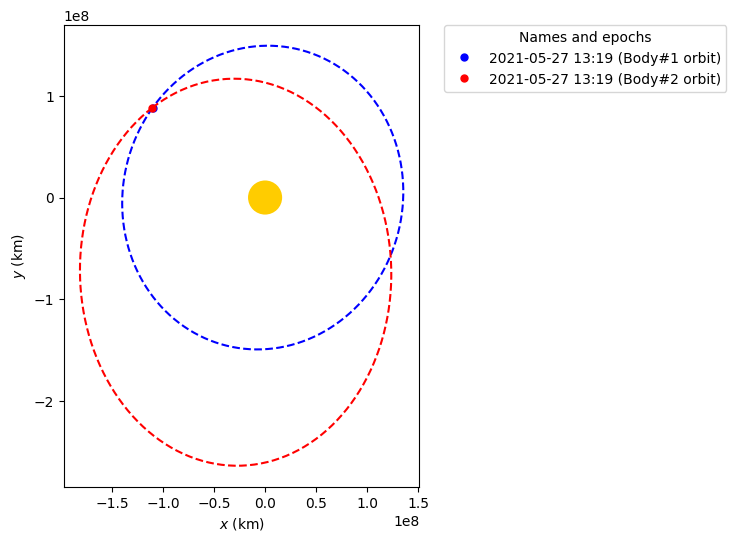

In [ ]:
orbit1, orbit2 = plot_orbits_2d(bodies_params=[BODY_1_PARAMS, BODY_2_PARAMS], result=result, time_in_JDT=TIME_OF_CALCULATION_IN_JDT)

In [ ]:
import numpy as np

from poliastro.bodies import Earth, Sun
from poliastro.constants import J2000
from poliastro.examples import churi, iss, molniya
from poliastro.plotting import OrbitPlotter3D
from poliastro.twobody import Orbit
# More info: https://plotly.com/python/renderers/
available_renderers=['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']
import plotly.io as pio

# pio.renderers.default = "plotly_mimetype+notebook_connected+colab+jupyterlab+vscode+notebook"
pio.renderers.default = "colab"


frame = OrbitPlotter3D()

# frame.plot_body_orbit(Earth, J2000)
frame.plot(orbit1, label="BODY#1")
frame.plot(orbit2, label="BODY#2", color="red")
